In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from cartopy.io.img_tiles import OSM
import cartopy


/home/atmo/bin/anaconda3/envs/rmaiwald_dev/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [3]:
from experiments import SensorPlacement
from experiments import utilities as utils
from bayesinverse import Regression
from emissions import WK84_MASK, data_loader, GRAL, GK_MASK, transform_to_WK84

import robiplotipy.experiments.sensor_placement as plt_exp
from robiplotipy import PlotEnv


In [4]:
config_path = config_path = Path(
    "/home/rmaiwald/code/Experiments/experiments/sensor_placement/config.yaml"
)

exp = SensorPlacement(config_path)


sensors 0.022467955946922302
emissions 7.080038160085678
transport 29.92672662436962


In [5]:
exp.load_data()


In [6]:
# Correct relative improvement
data_dict = exp.data["relative_gain_dict"]
best_data_dict = exp.data["best_relative_gain_dict"]
for key in data_dict.keys():
    data_dict[key] = np.array(data_dict[key]) * 100
    best_data_dict[key] = np.array(best_data_dict[key]) * 100
exp.data["relative_gain_dict"] = data_dict
exp.data["best_relative_gain_dict"] = best_data_dict

In [7]:
# Look at outlier
def print_outlier_summary(data_dict):
    for key in data_dict.keys():
        print(f"Sensors: {key}")
        ar = np.array(data_dict[key])
        mean = ar.mean()
        std = ar.std()
        min_val, max_val = ar.min(), ar.max()
        n_total = ar.shape[0]
        outlier_mask = np.abs(ar - mean) >= 3 * std
        n_outlier = outlier_mask.sum()

        new_min_val, new_max_val = ar[~outlier_mask].min(), ar[~outlier_mask].max()
        print(f"mean: {mean:.2f}")
        print(f"std: {std:.2f}")
        print(f"min/max: {min_val:.2f}/{max_val:.2f}")
        print(f"Outlier: {n_outlier}/{n_total}")
        print(f"New min/max: {new_min_val:.2f}/{new_max_val:.2f}")
        print()


def filter_outlier(data_dict):
    for key in data_dict.keys():
        ar = np.array(data_dict[key])
        mean = ar.mean()
        std = ar.std()
        outlier_mask = np.abs(ar - mean) >= 3 * std
        data_dict[key] = ar[~outlier_mask]
    return data_dict


In [8]:
data_label_list = ["information_dict", "dof_dict", "error_reduction_dict", "relative_gain_dict"]
for label in data_label_list:
    print(label)
    print_outlier_summary(exp.data[label])
    # exp.data[label] = filter_outlier(exp.data[label])
    print()

information_dict
Sensors: 9
mean: 76.57
std: 12.28
min/max: 35.45/111.56
Outlier: 3/500
New min/max: 45.61/111.56

Sensors: 12
mean: 89.52
std: 10.99
min/max: 45.08/122.65
Outlier: 2/500
New min/max: 57.82/118.42

Sensors: 16
mean: 102.67
std: 10.40
min/max: 72.79/127.39
Outlier: 0/500
New min/max: 72.79/127.39

Sensors: 20
mean: 114.27
std: 10.22
min/max: 79.96/141.63
Outlier: 1/500
New min/max: 83.87/141.63

Sensors: 25
mean: 124.26
std: 8.65
min/max: 88.38/146.62
Outlier: 1/500
New min/max: 99.56/146.62


dof_dict
Sensors: 9
mean: 37.11
std: 4.54
min/max: 17.89/45.92
Outlier: 3/500
New min/max: 24.03/45.92

Sensors: 12
mean: 40.95
std: 3.33
min/max: 20.52/48.35
Outlier: 5/500
New min/max: 31.86/48.35

Sensors: 16
mean: 44.09
std: 2.62
min/max: 32.48/48.91
Outlier: 5/500
New min/max: 36.42/48.91

Sensors: 20
mean: 46.00
std: 2.16
min/max: 35.72/49.79
Outlier: 8/500
New min/max: 39.53/49.79

Sensors: 25
mean: 47.58
std: 1.51
min/max: 39.37/50.53
Outlier: 7/500
New min/max: 43.42/50.53

In [9]:
plot_env = PlotEnv(
    fig_path="/home/rmaiwald/results/plotting/sensor_placement",
    logging=True,
    display=True,
)


[Errno 17] File exists: '/home/rmaiwald/results/plotting/sensor_placement/hist_information/config_log.yml'
[Errno 17] File exists: '/home/rmaiwald/results/plotting/sensor_placement/hist_dof/config_log.yml'
[Errno 17] File exists: '/home/rmaiwald/results/plotting/sensor_placement/hist_error_reduction/config_log.yml'
[Errno 17] File exists: '/home/rmaiwald/results/plotting/sensor_placement/hist_relative_improvement/config_log.yml'


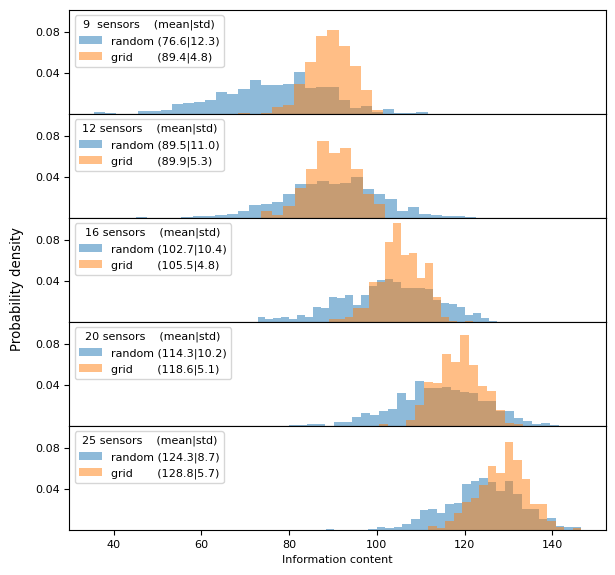

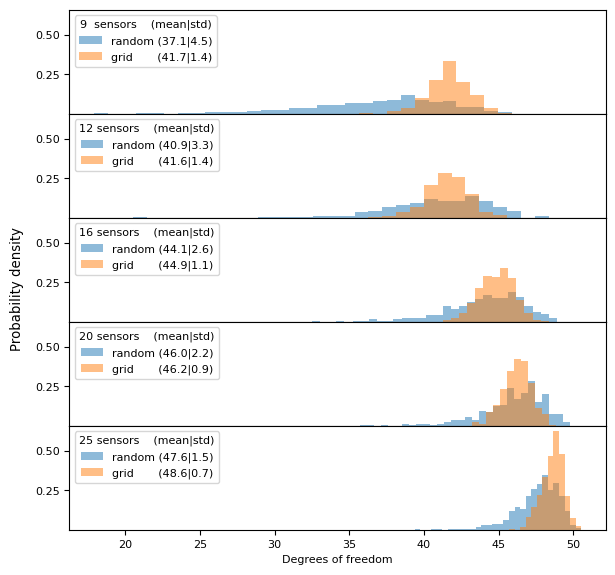

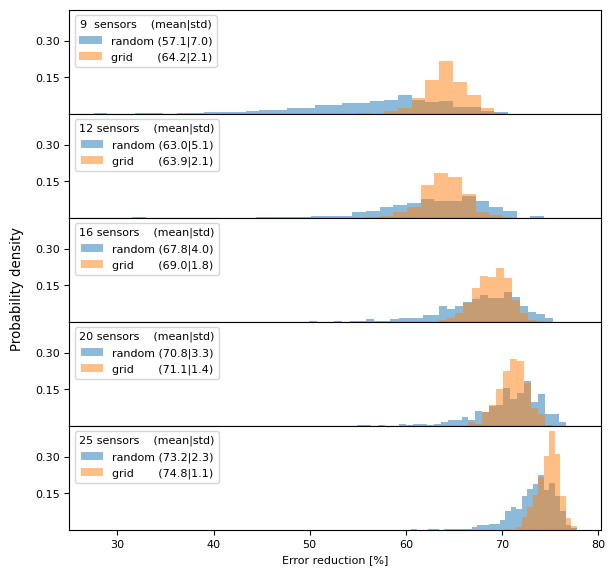

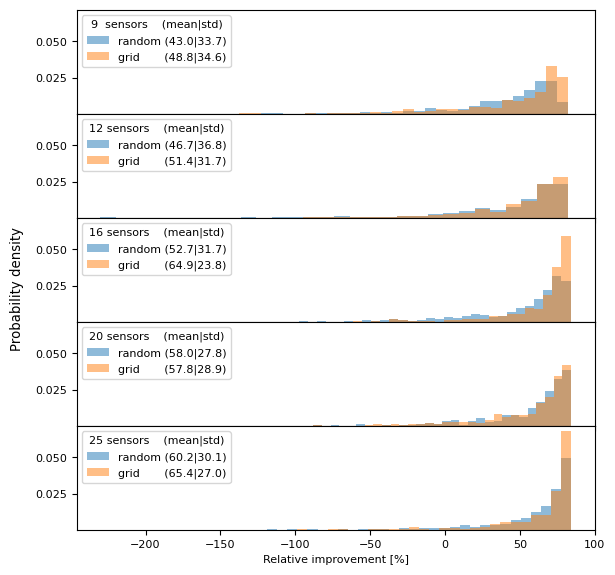

In [10]:
with plot_env(
    name="hist_information",
    notes=exp.config,
):
    plt_exp.plot_hist(
        env=plot_env,
        data_dict=exp.data["information_dict"],
        best_data_dict=exp.data["best_information_dict"],
        xlabel="Information content",
    )

with plot_env(
    name="hist_dof",
    notes=exp.config,
):
    plt_exp.plot_hist(
        env=plot_env,
        data_dict=exp.data["dof_dict"],
        best_data_dict=exp.data["best_dof_dict"],
        xlabel="Degrees of freedom",
    )

with plot_env(
    name="hist_error_reduction",
    notes=exp.config,
):
    plt_exp.plot_hist(
        env=plot_env,
        data_dict=exp.data["error_reduction_dict"],
        best_data_dict=exp.data["best_error_reduction_dict"],
        xlabel="Error reduction [%]",
    )

with plot_env(
    name="hist_relative_improvement",
    notes=exp.config,
):
    plt_exp.plot_hist(
        env=plot_env,
        data_dict=exp.data["relative_gain_dict"],
        best_data_dict=exp.data["best_relative_gain_dict"],
        xlabel="Relative improvement [%]",
    )


## Analyse best positions

Steps
1. Identify the indices of the 10% MC runs
2. Identify the measurement positions of these runs
3. Plot the positions

In [11]:
# 1. Best MC runs
n_best = 10
n_sample = 9
mc_index = np.arange(len(exp.data["information_dict"][n_sample]))
# Sort by most information content
mc_index = mc_index[np.array(exp.data["information_dict"][n_sample]).argsort()][
    -n_best:
]


In [12]:
# 2. Positions of the measurement stations
sensor_ids_array = np.array(exp.data["sensor_ids_dict"][n_sample])[mc_index]

sensor_index = exp.sensors.get_index()
x_positions = sensor_index[0][sensor_ids_array].flatten()
y_positions = sensor_index[1][sensor_ids_array].flatten()

total_positions, total_counts = np.unique(
    [x_positions, y_positions], axis=1, return_counts=True
)


In [13]:
# Convert positions to GRAL grid
total_positions[0] = total_positions[0] * GRAL.dx + GRAL.xmin
total_positions[1] = total_positions[1] * GRAL.dy + GRAL.ymin


In [14]:
# Load some background data
file_path = Path("/mnt/data/users/rmaiwald/GRAMM-GRAL/emissions/pickle_jar")

with open(file_path / "tno_gdf.pkl", "rb") as file:
    tno_gdf = pickle.load(file)

with open(file_path / "tno_df.pkl", "rb") as file:
    tno_df = pickle.load(file)

with open(file_path / "tno_point_gdf.pkl", "rb") as file:
    tno_point_gdf = pickle.load(file)

data_path = Path(
    "/mnt/data/users/rmaiwald/GRAMM-GRAL/emissions/ghg_heidelberg/ghg_heidelberg.dbf"
)
traffic_gdf = data_loader.get_new_traffic_gdf(data_path)
traffic_gdf["CO2[kt/year/km]"] = traffic_gdf["CO2[kg/year/m]"] * 1e-3

data_path = Path(
    "/mnt/data/GRAMM-GRAL-Input/tuto_data/emissions/HD/HD_heat_traffic.gdb"
)
heating_gdf = data_loader.get_heating_gdf(data_path)
heating_gdf["CO2[kt/year]"] = heating_gdf["CO2[kg/year]"] * 1e-6


/tmp/ipykernel_3422668/2053331739.py:5: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  tno_gdf = pickle.load(file)
/tmp/ipykernel_3422668/2053331739.py:11: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  tno_point_gdf = pickle.load(file)
ERROR 1: PROJ: proj_identify: /home/atmo/bin/anaconda3/envs/rmaiwald_dev/lib/python3.9/site-packages/fiona/proj_data/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 0 whereas a number >= 2 is expected. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /home/atmo/bin/anaconda3/envs/rmaiwald_dev/lib/python3.9/site-packages/fiona/proj_data/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 0 whereas a number >= 2 is expected. It comes from another PROJ installation.


In [15]:
exp.data["tno_gdf"] = tno_gdf
exp.data["tno_df"] = tno_df
exp.data["tno_point_gdf"] = tno_point_gdf

exp.data["traffic_gdf"] = traffic_gdf
exp.data["heating_gdf"] = heating_gdf

exp.data["total_counts"] = total_counts
exp.data["total_positions"] = total_positions


In [16]:
mindex = pd.MultiIndex.from_product([tno_df.columns.levels[0], ["co2_bf", "co2_ff"]])


In [17]:
tno_point_gdf

,geometry,"(A, co2_ff)","(A, co_ff)","(A, co2_bf)","(A, co_bf)","(B, co2_ff)","(B, co_ff)","(B, co2_bf)","(B, co_bf)","(C, co2_ff)",...,"(I, co2_bf)","(I, co_bf)","(J, co2_ff)","(J, co_ff)","(J, co2_bf)","(J, co_bf)","(L, co2_ff)","(L, co_ff)","(L, co2_bf)","(L, co_bf)"
0,POINT (3477239.291 5469116.240),0.000000e+00,0.000000,0.0,0.0,4.269947e+08,580364.143764,2.100532e+07,56635.856236,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,POINT (3476324.539 5476119.419),5.326485e+07,267396.031534,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


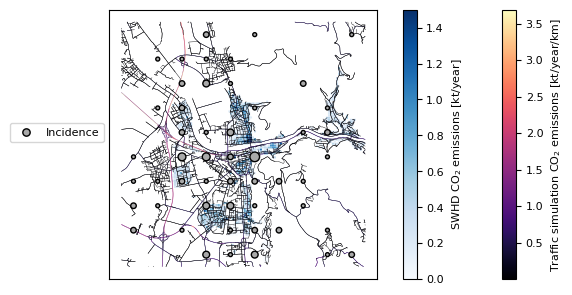

In [18]:
with plot_env(
    name="sensor_position",
    notes=exp.config,
):
    plt_exp.plot_sensor_counts(env=plot_env, exp=exp)


[Errno 17] File exists: '/home/rmaiwald/results/plotting/sensor_placement/sensor_position_osm/config_log.yml'


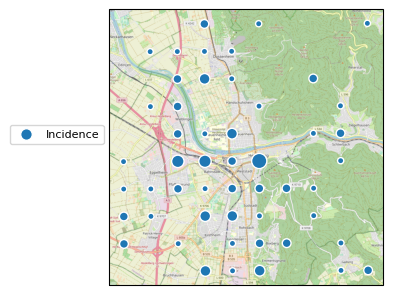

In [19]:
with plot_env(
    name="sensor_position_osm",
    notes=exp.config,
):
    plt_exp.plot_sensor_counts_osm(env=plot_env, exp=exp)
